In [1]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import  models

In [2]:
warnings.filterwarnings("ignore")

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


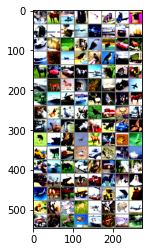

  cat horse  ship truck


In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [6]:
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = models.resnet18(pretrained=True)
num_ftrs = net.fc.in_features
net.fc = nn.Sequential(nn.Linear(num_ftrs, 256),
                             nn.ReLU(),
                             nn.Dropout(0.2),
                             nn.Linear(256, len(classes)))

net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [8]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
    print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / len(trainloader)))
    running_loss = 0.0

print('Finished Training')

[1,   391] loss: 1.358
[2,   391] loss: 0.777
Finished Training


In [9]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


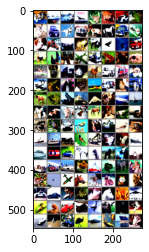

GroundTruth:    cat  ship  ship plane


In [10]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [11]:
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [12]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


In [13]:
outputs

tensor([[-1.5420, -0.5482,  0.6908,  ..., -0.4490, -1.2280, -0.8466],
        [ 1.0747,  4.5830, -1.8205,  ..., -2.8325,  7.3465,  1.0740],
        [ 0.2892,  2.7758, -1.1429,  ..., -0.2965,  3.4374,  1.6116],
        ...,
        [ 3.5683, -0.9946,  1.1232,  ..., -1.7820,  3.3860, -0.5493],
        [ 2.8155, -0.9989, -0.5766,  ..., -1.3831,  5.3590,  1.3921],
        [-1.4129, -2.6399,  1.4063,  ...,  1.6073, -2.5886, -2.4878]],
       grad_fn=<AddmmBackward>)

In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 73 %
